## Develop Log_dt Metric

Gordon Richards (Drexel), Weixiang Yu (Drexel), with input from Paolo Coppi (Yale); August 2020

This notebook is an exploration of the distribution of pairs of observations.  We are comparing DDF observations to WFD observations in the same part of the sky and comparing 4 different opSims created with the DDFs specifically in mind (or that serve as a baseline for them).

In [1]:
#Please enter your SciServer username between the single quotes below!
your_username = ''

<!-- <b>Now we can start computing metrics to use for comparing different opSims.</b> -->

### 0. Software Setup (repeat each session)

In [2]:
# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os

In [3]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.2,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
#     "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 20,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis    
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 20,
    "legend.fontsize": 20,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 20,              # Font size of numbers 
    "ytick.labelsize": 20,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.top":True,
    "xtick.minor.top":True,
    "ytick.major.right":True,
    "ytick.minor.right":True,
    'xtick.major.width':1.0, 
    'xtick.minor.width':1.0, 
    'ytick.major.width':1.0, 
    'ytick.minor.width':1.0, 
    'xtick.major.size':8,             # size of tickmarks in points
    'xtick.minor.size':4, 
    'ytick.major.size':8, 
    'ytick.minor.size':4,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
#     "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
#     "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
#         r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
#         ]
    }

mpl.rcParams.update(pgf_with_latex)

Import the sims_maf modules needed.

In [4]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

In [5]:
# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

In [6]:
from opsimUtils import *

### 1. Define `LogTgaps` Metric

In [7]:
# the base 10 log of 30sec and 10 years in dasy are
# but the bins really aren't needed for the metric, the metric only return Tgaps. 
np.log10([30/3600/24, 3650])

array([-3.45939249,  3.56229286])

In [8]:
from lsst.sims.maf.metrics import BaseMetric

class LogTgapsMetric(BaseMetric):
    """Histogram the times of the gaps between observations.


    Measure the gaps between observations.  By default, only gaps
    between neighboring visits are computed.  If allGaps is set to true, all gaps are
    computed (i.e., if there are observations at 10, 20, 30 and 40 the default will
    return a histogram of [10,10,10] while allGaps returns a histogram of [10,10,10,20,20,30])

    Parameters
    ----------
    timesCol : str, opt
        The column name for the exposure times.  Values assumed to be in days.
        Default observationStartMJD.
    allGaps : bool, opt
        Histogram the gaps between all observations (True) or just successive observations (False)?
        Default is False. If all gaps are used, this metric can become significantly slower.
    bins : np.ndarray, opt
        The bins to use for the histogram of time gaps (in days, or same units as timesCol).
        Default values are bins from 0 to 2 hours, in 5 minute intervals.

    Returns a histogram at each slice point; these histograms can be combined and plotted using the
    'SummaryHistogram plotter'.
     """

    def __init__(self, timesCol='observationStartMJD', allGaps=False, bins=np.logspace(-3.46, 3.56, 100),
                 units='days', **kwargs):
        # Pass the same bins to the plotter.
        self.bins = bins
        self.timesCol = timesCol
        super(LogTgapsMetric, self).__init__(col=[self.timesCol], metricDtype='object', units=units, **kwargs)
        self.allGaps = allGaps

    def run(self, dataSlice, slicePoint=None):
        if dataSlice.size < 2:
            return self.badval
        times = np.sort(dataSlice[self.timesCol])
        if self.allGaps:
            allDiffs = []
            for i in np.arange(1,times.size,1):
                allDiffs.append((times-np.roll(times,i))[i:])
            dts = np.concatenate(allDiffs)
        else:
            dts = np.diff(times)
#         result, bins = np.histogram(dts, self.bins)
        return dts

Load up the 4 opSims that we want to compare.  The AGN SC's proposal, the DESC proposal, the "Daily" DDF opSim, and "baseline" (for comparison).  With just these 4 I haven't bothered to set things up as a loop over them.

In [9]:
#Read in an opSim (in this case "baseline_v1.4_10yrs.db")
opsdb1 = db.OpsimDatabase('/home/idies/workspace/lsst_cadence/FBS_1.5/baseline_v1.5_10yrs.db')
opsdb2 = db.OpsimDatabase('/home/idies/workspace/lsst_cadence/FBS_1.5/daily_ddf_v1.5_10yrs.db')
opsdb3 = db.OpsimDatabase('/home/idies/workspace/lsst_cadence/FBS_1.5/agnddf_v1.5_10yrs.db')
opsdb4 = db.OpsimDatabase('/home/idies/workspace/lsst_cadence/FBS_1.5/descddf_v1.5_10yrs.db')

if your_username == '':
    raise Exception('Please provide your username!  See the top of this notebook.')
    
outDir = '/home/idies/scr/tmp/MAFOutput/LogTGaps/ResultDbs/'
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
resultsDb = db.ResultsDb(outDir=outDir)

In [10]:
#The DDFs aren't recorded in the same way for each opSim, so we need to figure out which "proposal" they correspond to.

print(ddfInfo(opsdb1, 'XMM-LSS'))
print(ddfInfo(opsdb2, 'XMM-LSS'))
print(ddfInfo(opsdb3, 'XMM-LSS'))
print(ddfInfo(opsdb4, 'XMM-LSS'))

{'proposalId': 6, 'Coord': (35.707, -4.72)}
{'proposalId': 5, 'Coord': (35.707, -4.72)}
{'proposalId': 5, 'Coord': (35.707, -4.72)}
{'proposalId': 4, 'Coord': (35.707, -4.72)}


#If we wanted to look at the COSMOS field instead of XMM-LSS, then run this cell instead.

print(ddfInfo(opsdb1, 'COSMOS'))
print(ddfInfo(opsdb2, 'COSMOS'))
print(ddfInfo(opsdb3, 'COSMOS'))
print(ddfInfo(opsdb4, 'COSMOS'))

### 2. Run Metric at the center of the DDF using pointslicer

In [11]:
# metric = is the number of pairs of observations, distributed in log space, thus "log t-gaps", which is based on one of the project-defined metrics.
metric1 = LogTgapsMetric(allGaps=True)

# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
#COSMOS
#slicer1 = slicers.UserPointsSlicer(ra=[150.11], dec=[2.14])
#XMMLSS
slicer1 = slicers.UserPointsSlicer(ra=[35.707], dec=[-4.72])

# constraint = the sql query (or 'select') that selects all visits in r band
constraint1 = 'filter = "r"'

Now set up the metric bundles.  Note that I made one for each opSim.  It is notclear that I need to do this way as I'm not changing the metric, but this is also where we extract the results from, so I think that I have to?

In [12]:
# MetricBundle = combination of the metric, slicer, and sqlconstraint
ddf_nvisit1 = metricBundles.MetricBundle(metric1, slicer1, constraint1)
bundleDict1 = {'logtgaps': ddf_nvisit1}

In [13]:
# MetricBundle = combination of the metric, slicer, and sqlconstraint
ddf_nvisit2 = metricBundles.MetricBundle(metric1, slicer1, constraint1)
bundleDict2 = {'logtgaps': ddf_nvisit2}

In [14]:
# MetricBundle = combination of the metric, slicer, and sqlconstraint
ddf_nvisit3 = metricBundles.MetricBundle(metric1, slicer1, constraint1)
bundleDict3 = {'logtgaps': ddf_nvisit3}

In [15]:
# MetricBundle = combination of the metric, slicer, and sqlconstraint
ddf_nvisit4 = metricBundles.MetricBundle(metric1, slicer1, constraint1)
bundleDict4 = {'logtgaps': ddf_nvisit4}

Now run the metric on each of the opSims defined above.

In [16]:
group1 = metricBundles.MetricBundleGroup(bundleDict1, opsdb1, outDir=outDir, resultsDb=resultsDb)
group1.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 491676 visits
Running:  ['logtgaps']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [17]:
group2 = metricBundles.MetricBundleGroup(bundleDict2, opsdb2, outDir=outDir, resultsDb=resultsDb)
group2.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 466286 visits
Running:  ['logtgaps']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [18]:
group3 = metricBundles.MetricBundleGroup(bundleDict3, opsdb3, outDir=outDir, resultsDb=resultsDb)
group3.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 469008 visits
Running:  ['logtgaps']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [19]:
group4 = metricBundles.MetricBundleGroup(bundleDict4, opsdb4, outDir=outDir, resultsDb=resultsDb)
group4.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 473116 visits
Running:  ['logtgaps']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Now make a plot comparing the pair distribution in log delta T for each of those opSims.

In [20]:
mask1 = ddf_nvisit1.metricValues.mask
data1 = ddf_nvisit1.metricValues.data[~mask1]

In [21]:
mask2 = ddf_nvisit2.metricValues.mask
data2 = ddf_nvisit2.metricValues.data[~mask2]

In [22]:
mask3 = ddf_nvisit3.metricValues.mask
data3 = ddf_nvisit3.metricValues.data[~mask3]

In [23]:
mask4 = ddf_nvisit4.metricValues.mask
data4 = ddf_nvisit4.metricValues.data[~mask4]

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


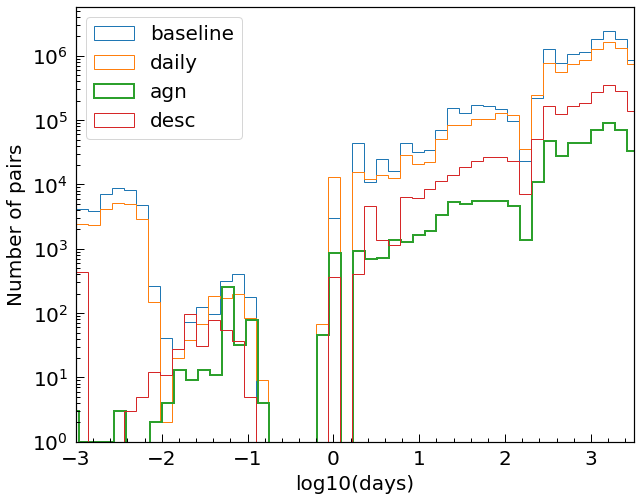

In [24]:
fig = plt.figure(figsize=(10,8))
plt.hist(np.log10(data1[0]), bins=50, log=True, histtype='step', label='baseline')
plt.hist(np.log10(data2[0]), bins=50, log=True, histtype='step', label='daily')
plt.hist(np.log10(data3[0]), bins=50, log=True, histtype='step', label='agn', linewidth=2)
plt.hist(np.log10(data4[0]), bins=50, log=True, histtype='step', label='desc')
plt.xlim(-3, 3.5)
plt.ylim(bottom=1)
plt.xlabel('log10(days)')
plt.ylabel('Number of pairs')
plt.legend(loc='upper left')
#plt.savefig('XMMLSS_r_manydbs.png')

OK, that was the result where we took all the observations in the DDF, regardless of whether they were "DDF" or "WFD" observations.  Now let's split them up.

The point is this: I'd like to define a metric in the WFD area.  However, no matter what we do there are going to be gaps and some timescales with inherently fewer (but non-zero) observations.  So, I'm thinking that it would be a good idea to scale the result from the WFD by the DDFs (as they represent the "best" that we could hope to achieve).  That would remove the upward-right sloping aspect of the log delta t plot above and maybe make it easier to compare different WFD results.  

I was thinking of averaging over all of the DDFs for the baseline opSim as the vector to normalize by.  A further question is how to normalize the WFD and the DDF results since clearly there are many more observation pairs in the DDFs.

Modify the above contraint to keep only the **WFD** observations ("not like DDF").

In [25]:
# metric = the "maximum" of the "airmass" for each group of visits in the slicer
#metric1b = LogTgapsMetric(allGaps=True)

# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
#slicer1b = slicers.UserPointsSlicer(ra=[150.11], dec=[2.14])

# constraint = the sql query (or 'select') that selects all visits in r band
constraint1b = 'filter = "r"'
constraint1b += ' and note not like "DD%"'

The next 3 cells define the metric bundle (and dict), run the metric on just the first opSim and extracts the data for plotting.

In [26]:
# MetricBundle = combination of the metric, slicer, and sqlconstraint
ddf_nvisit1b = metricBundles.MetricBundle(metric1, slicer1, constraint1b)
bundleDict1b = {'logtgaps': ddf_nvisit1b}

In [27]:
group1b = metricBundles.MetricBundleGroup(bundleDict1b, opsdb1, outDir=outDir, resultsDb=resultsDb)
group1b.runAll()

Querying database SummaryAllProps with constraint filter = "r" and note not like "DD%" for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 467643 visits
Running:  ['logtgaps']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [28]:
mask1b = ddf_nvisit1b.metricValues.mask
data1b = ddf_nvisit1b.metricValues.data[~mask1b]

Do the same as above, now modifying the above contraint to keep only the **DDF** observations ("not DDF").

In [29]:
# metric = the "maximum" of the "airmass" for each group of visits in the slicer
#metric1b = LogTgapsMetric(allGaps=True)

# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
#slicer1b = slicers.UserPointsSlicer(ra=[150.11], dec=[2.14])

# constraint = the sql query (or 'select') that selects all visits in r band
constraint1c = 'filter = "r"'
constraint1c += ' and note like "DD%"'

In [30]:
# MetricBundle = combination of the metric, slicer, and sqlconstraint
ddf_nvisit1c = metricBundles.MetricBundle(metric1, slicer1, constraint1c)
bundleDict1c = {'logtgaps': ddf_nvisit1c}

In [31]:
group1c = metricBundles.MetricBundleGroup(bundleDict1c, opsdb1, outDir=outDir, resultsDb=resultsDb)
group1c.runAll()

Querying database SummaryAllProps with constraint filter = "r" and note like "DD%" for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 24033 visits
Running:  ['logtgaps']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [32]:
mask1c = ddf_nvisit1c.metricValues.mask
data1c = ddf_nvisit1c.metricValues.data[~mask1c]

Now compare the result for all the observations, the DDF observations only, and the WFD observations.

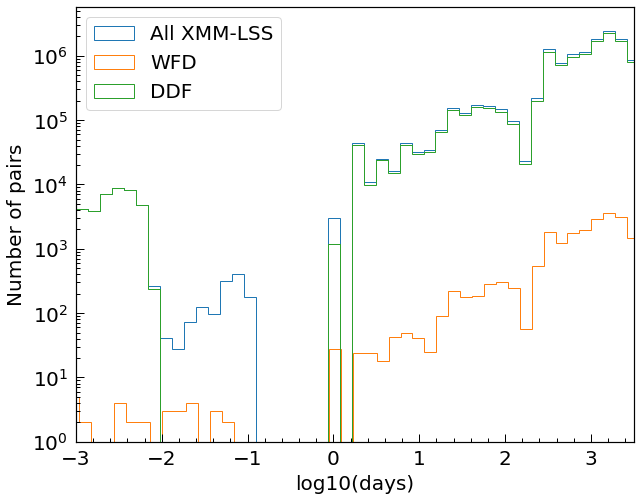

In [33]:
fig = plt.figure(figsize=(10,8))
plt.hist(np.log10(data1[0]), bins=50, log=True, histtype='step', label='All XMM-LSS')
plt.hist(np.log10(data1b[0]), bins=50, log=True, histtype='step', label='WFD')
plt.hist(np.log10(data1c[0]), bins=50, log=True, histtype='step', label='DDF')

plt.xlim(-3, 3.5)
plt.ylim(bottom=1)
plt.xlabel('log10(days)')
plt.ylabel('Number of pairs')
plt.legend(loc='upper left')
#plt.savefig('XMMLSS_r_WFD_DDF_baseline.png')

---

What I was going to do next was to take the DDF result, use it to normalize the WFD results.  Then compute a metric that captures how well samples the log delta t distribution is for each opSim, relative to the "best case" scenario as given by the DDFs.  This could use all timescales (probably dropping the lowest timescales), or just sample ~3 representative bins.  Ideally do it for all the bands.  Not quite clear how to combine their information together.

---

Below here is left over code from the notebook that I copied this from.  Keeping it just in case.

---

### 3. Run Metric across the WFD using healpix slicer and average it

# metric = the "maximum" of the "airmass" for each group of visits in the slicer
metric0 = LogTgapsMetric(allGaps=True)

# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
slicer0 = slicers.HealpixSlicer(nside=64)

# constraint = the sql query (or 'select') that selects all visits in r band
constraint0 = 'filter = "i"'
constraint0 += ' and note not like "DD%"'
constraint0 += ' and proposalId = 1'

# MetricBundle = combination of the metric, slicer, and sqlconstraint
wfd_nvisit0 = metricBundles.MetricBundle(metric0, slicer0, constraint0)
bundleDict0 = {'logtgaps': wfd_nvisit0}

group0 = metricBundles.MetricBundleGroup(bundleDict0, opsdb1, outDir=outDir, resultsDb=resultsDb)
group0.runAll()

#### 2.1 Make plot directly

mask0 = wfd_nvisit0.metricValues.mask
data0 = wfd_nvisit0.metricValues.data[~mask0]

data0_flat = np.concatenate(data0)
data0_flat.shape

# compute averaged logTgaps in WFD
n, edges = np.histogram(np.log10(data0_flat), bins=50)
n = n/data0.shape[0] #divide by number of pixels

left,right = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([n,n]).T.flatten()

fig = plt.figure(figsize=(10,8))
plt.hist(np.log10(data1[0]), bins=50, log=True, histtype='step', label='COSMOS')
plt.plot(X, Y, label='Averaged WFD')
# plt.yscale('log')
plt.xlim(-3, 3.5)
plt.ylim(bottom=1) # set lower number on count to 1
plt.xlabel('log10(days)')
plt.ylabel('Number of pairs')
plt.title('LogTgaps in COSMOS vs. in WFD')
plt.legend(loc=2)